# Intution

 With this tutorial, I present how to create a emotion classifier using FER2013 dataset.

FER2013 is a large, publicly available Face Expression Recognition(FER) dataset consisting of 35,887 face crops. The dataset is challenging as the depicted faces vary significantly in terms of person age, face pose, and other factors, reflecting realistic conditions. The dataset is split into training, validation, and test sets samples. All images are grayscale i.e. only 1 channel and have a resolution of 48 by 48 pixels. Basic expression labels are provided for all samples.The goal is to categorize the emotions into the following seven categories:

- Angry
- Disgust
- Fear
- Happy
- Sad
- Surprise
- Neutral

Recognizing the emotions under controlled conditions is simpler. But what makes this task challenging is to account for naturalistic conditions like different poses, illumination, etc and the fact that unposed expressions are often subtle.

Link: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

We will build a Convolutional Neural Networks to identify the expressions.

*Accuracy is an important consideration for any neural network but the focus of this tutorial will be to optimize the network to also do faster inferencing with an acceptable loss of accuracy. Running on a resource constrained device should not be a constraint and expression recognition could be done at the edge. We will see some techniques to achieve this.*

# Loading the Data

Dataset used for training is available on Kaggle. You can download it and extract locally or optionally upload to Google drive (if you don't heavy computing resources like gpu.)

**Downloaded dataset is availabe in data folder**

In [12]:
import pandas 
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pandas.read_csv('drive/My Drive/EmotionDetection/Fer_data/fer2013.csv')

# Data sampling and pre-processing

In [4]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Each data sample has below entries

- **emotion:** one of the emotion represented as integer
- **pixels:** pixel values for the image.
- **Usage:** whether the sample should be used for training or test.

Now lets see the samples distribution across different sample sets(training or test) and in the emotion classes:

In [5]:
print('Samples distribution across Usage:')
print(data.Usage.value_counts())

Samples distribution across Usage:
Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64



So we have a total of 35,887 images divided into three data sets:

- Training - which we will use to train our model, by pairing the input with expected output.

- PrivateTest - which will be used to validate our model on to fine tune model weights and biases.

- PublicTest - this dataset will be used to evaluate our model after training is over. This dataset was made public after the competition had officially ended. It is not expected to use PublicTest dataset anywhere in training phase as the accuracy and error rate estimate will be biased since the model has seen those images. We will be strictly using it to evaluate the trained model.

In [6]:
print("Sample per emotion:")
print(data.emotion.value_counts())

Sample per emotion:
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


There are 7 emotions labelled 0 to 6 as discussed earlier. What is obvious from the samples distribution is that there is non-uniformity among different emotion classes We have ~9k samples for "fear" and only 547 for "disgust". This has a big impact on how well your model can perform. Well, we will try to deal with it

In [7]:
print('Number of pixels for a sample:')
print(len(data.pixels[0].split(" ")))

Number of pixels for a sample:
2304


Pixel size for each of the sample is 2304. It can be visulaized as a 2D-matrix of 48x48. We do this conversion prior to feeding it to our network. The pixel values are in grayscale. They have a single value for each pixel which represent the intensity of the pixel.

Below code cells do the conversion and we will then see how the samples look.

Firstly, dataset is categorzied into training, validation and test sets depending on the Usage value for the samples

In [46]:
train_set = data[(data.Usage == 'Training')]
val_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')]



We label the seven emotion classes and store as a list.



In [14]:
emotion_labels = ["Angry" , "Disgust" , "Fear","Happy","Sad","Surprise","Neutral"]
num_classes = len(emotion_labels)

Each sample has 2304 pixels. Converting it to a 2D matrix gives a 48x48 image i.e. width and height is 48 each and depth is 1 as there is only 1 channel (for grayscale image)

In [48]:
from math import sqrt

depth = 1
height = int(sqrt(len(data.pixels[0].split(' '))))
width = height
print(height)

48


Now, lets visualize some of our data. Choose a sample number from the slider and run the cell. It displays the image from training and the emotion class it belongs to:



Angry


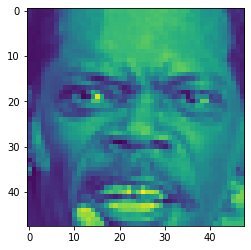

In [37]:
sample_num = 10
import cv2
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display

image = np.reshape(data.at[sample_num, "pixels"].split(" "), (height, width)).astype("float")
plt.imshow(image)
print(emotion_labels[data.emotion[sample_num]])

Below function is used to preprocess and transform data from csv file to numpy array

In [50]:
def csv_Prepro(dataSet):
  X = []
  for pixel in dataSet.pixels:
        image = np.reshape(pixel.split(" "), (height, width)).astype("float")
        X.append(image)

  X = np.expand_dims(np.array(X), -1)  

  return X    


In [51]:
X_train = csv_Prepro(train_set)
X_test = csv_Prepro(test_set)
X_val = csv_Prepro(val_set)
print('Training: ',X_train.shape)
print('Validation: ',X_val.shape)
print('Test: ',X_test.shape)

Training:  (28709, 48, 48, 1)
Validation:  (3589, 48, 48, 1)
Test:  (3589, 48, 48, 1)


The value of emotion is one of [0,1,2,3,4,5,6]. We convert it one-hot word encoding such that each emotion is represented as 1x7 vector.

Summarizing the above, the output; a number representing an emotion is transformed to a binary class matrix. Each samples output will be a vector of 7 each representing the particular emotion class.

e.g. if the emotion class is 5 it will become [0. 0. 0. 0. 1. 0. 0.]

In [53]:
from keras.utils import np_utils

y_train = train_set.emotion
y_train = np_utils.to_categorical(y_train, num_classes)

y_validation = val_set.emotion
y_validation = np_utils.to_categorical(y_validation, num_classes)

y_test = test_set.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

print('Training: ',y_train.shape)
print('Validation: ',y_validation.shape)
print('Test: ',y_test.shape)

Training:  (28709, 7)
Validation:  (3589, 7)
Test:  (3589, 7)


In [54]:
X_train = np.concatenate((X_train , X_val) , axis = 0)
y_train = np.concatenate((y_train , y_validation) , axis = 0)

Saving the numpy arrays as .npz file in *Training_data* folder for future use.

In [55]:
np.savez("drive/My Drive/EmotionDetection/Training_data/train.npz" , X = X_train , Y = y_train )
np.savez("drive/My Drive/EmotionDetection/Training_data/test.npz" , X = X_test , Y = y_test )